In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # 准确率
#aaa
##bbbb
import numpy as np
import urllib.request
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn
import joblib
import hdf5storage
import itertools
import h5py
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother
from tsmoothie.utils_func import sim_seasonal_data
from tsmoothie.smoother import DecomposeSmoother
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import joblib
import pickle
from sklearn.datasets import load_iris

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
def smooth(data):
    # operate smoothing
    #参数整定
    smoother = DecomposeSmoother(smooth_type='lowess', periods=50,
                                smooth_fraction=0.2)
    smoother.smooth(data)
    low, up = smoother.get_intervals('sigma_interval')
    return smoother.smooth_data # 处理后的数据

def cul_data(path):
    """
    cul_data处理

    path:  数据所在的文件路径

    return: 返回值是处理后的结果
    """
    # num = int(path[-5])  # 读取文件命名
    f = hdf5storage.loadmat(path)
    # if num == 0:
    #     element_name = 'MM_multi_MA_'
    # else:
    #     element_name = 'MM_multi_MA_0'

    if path == '../data/All_MM_MA_ganlanshi.mat' :
        element_name = 'MM_multi_MA_01'
    elif path == '../data/All_MM_MA_jun.mat':
        element_name = 'MM_multi_MA_04'

    src_data = np.array(f[element_name])

    ## 阵元归一
    divisor = src_data[0,:]

    divisor = divisor[np.newaxis,:]
    # print(divisor.shape)

    temp_data = src_data / divisor

    num_cols = temp_data.shape[1]
    k = 1000
    random_cols = np.random.choice(num_cols, k, replace=False)
    sm_data = temp_data[:,random_cols]
    # return sm_data
    return temp_data

def add_label(data, label):
    '''
    add_label:

    data:原始数据

    label: 标签
    
    return: 
    '''
    news_row = np.array([label] *data.shape[1])

    arr = np.vstack((data, news_row))
    
    return arr

def handle_data():
    '''
        return: 整个数据集 滤波后的数据
    '''
    path = ['../data/All_MM_MA_ganlanshi.mat', '../data/All_MM_MA_jun.mat']

    k = 0
    all_data_test = []
    for i in path:
        temp_data = cul_data(i)
        # temp_data = smooth(temp_data)
        all_data_test.append(add_label(temp_data, k))
        k = k+1
    return all_data_test

def merge_data(data):
    '''
    data: 传入列表数据
    return: 合并后的数组 arr
    '''
    k = 1000  ## 取前一万个数据

    num_cols = data[0].shape[1]

    random_cols = np.random.choice(num_cols, k, replace=False)
    temp_data = data[0][:,random_cols]

    for i in range(1, len(data)):
        num_cols = data[i].shape[1]

        random_cols = np.random.choice(num_cols, k, replace=False)
        merge_arr = np.concatenate((temp_data, data[i][:,random_cols]), axis=1)
        temp_data = merge_arr

    return temp_data


In [3]:
temp_val_data = handle_data()

all_data = merge_data(temp_val_data)

Labels = all_data[-1,:].T

all_Features = all_data[:-1, :].T

print(Labels.shape)
print(all_Features.shape)

(2000,)
(2000, 16)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(all_Features, Labels, test_size=0.2, random_state=42)

#标准化单位方差
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

lda = LDA(n_components=1)
lr = LogisticRegression()

#训练
x_train_lda = lda.fit_transform(x_train_std, y_train)
#测试
# x_test_lda = lda.transform(x_test, y_test)
#拟合
lr.fit(x_train_std, y_train)

LogisticRegression()

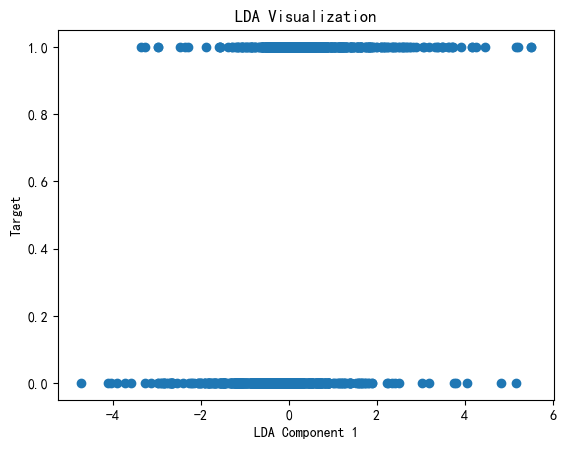

In [5]:
# 绘制散点图
plt.scatter(x_train_lda, y_train)
# plt.plot(x_train_lda, y_train)
plt.xlabel('LDA Component 1')
plt.ylabel('Target')
plt.title('LDA Visualization')
plt.show()

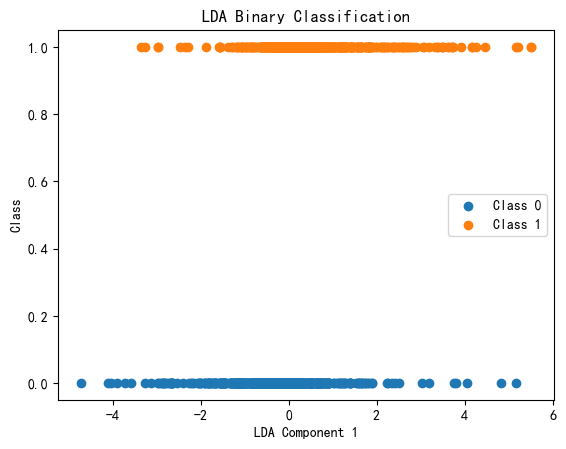

In [6]:
# 获取两个类别的索引
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

# 绘制散点图
plt.scatter(x_train_lda[class_0_indices], np.zeros_like(class_0_indices), label='Class 0')
plt.scatter(x_train_lda[class_1_indices], np.ones_like(class_1_indices), label='Class 1')

plt.xlabel('LDA Component 1')
plt.ylabel('Class')
plt.title('LDA Binary Classification')
plt.legend()
plt.show()

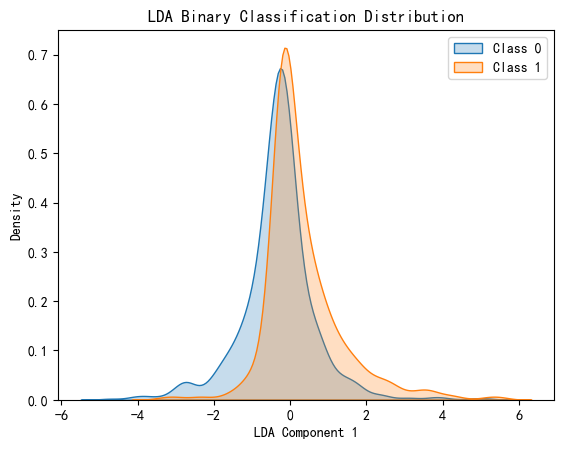

In [7]:
# 获取两个类别的数据
class_0_data = x_train_lda[y_train == 0]
class_1_data = x_train_lda[y_train == 1]

# 绘制分布图
sns.kdeplot(class_0_data.flatten(), fill=True, label='Class 0')
sns.kdeplot(class_1_data.flatten(), fill=True, label='Class 1')

plt.xlabel('LDA Component 1')
plt.ylabel('Density')
plt.title('LDA Binary Classification Distribution')
plt.legend()
plt.show()

In [17]:
#可视化函数
def plot_decision_regions(x, y, classifier, resolution=0.02):
    markers = ['s', 'x', 'o', '^', 'v']
    colors = ['r', 'g', 'b', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
 
    for idx, cc in enumerate(np.unique(y)):
        plt.scatter(x=x[y == cc, 0],
                    y=x[y == cc, 1],
                    alpha=0.6,
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cc)

# 画图高宽，像素
plt.figure(figsize=(6, 7), dpi=100)  
plot_decision_regions(x_train_lda, y_train, classifier=lr)
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 600x700 with 0 Axes>

In [14]:
iris = load_iris()
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=22)
#标准化单位方差
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

lda = LDA(n_components=2)
lr = LogisticRegression()

#训练
x_train_lda = lda.fit_transform(x_train_std, y_train)
#测试
x_test_lda = lda.fit_transform(x_test_std, y_test)
#拟合
lr.fit(x_train_lda, y_train)


LogisticRegression()

C:\Users\jq_sc\AppData\Local\Temp\ipykernel_39508\1009122339.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y == cc, 0],
C:\Users\jq_sc\AppData\Local\Temp\ipykernel_39508\1009122339.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=x[y == cc, 0],


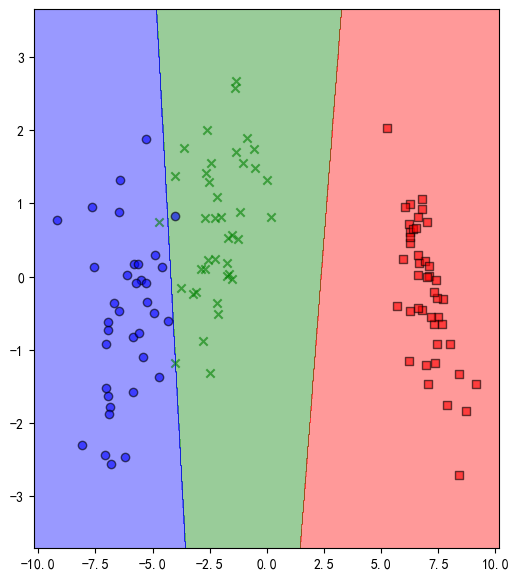

In [13]:
# 画图高宽，像素
plt.figure(figsize=(6, 7), dpi=100)  
plot_decision_regions(x_train_lda, y_train, classifier=lr)
plt.show()